Searching λ for Training Loss...
Searching λ for Deterministic Holdout...
Searching λ for K-Fold CV...
Searching λ for Residual Bootstrap...


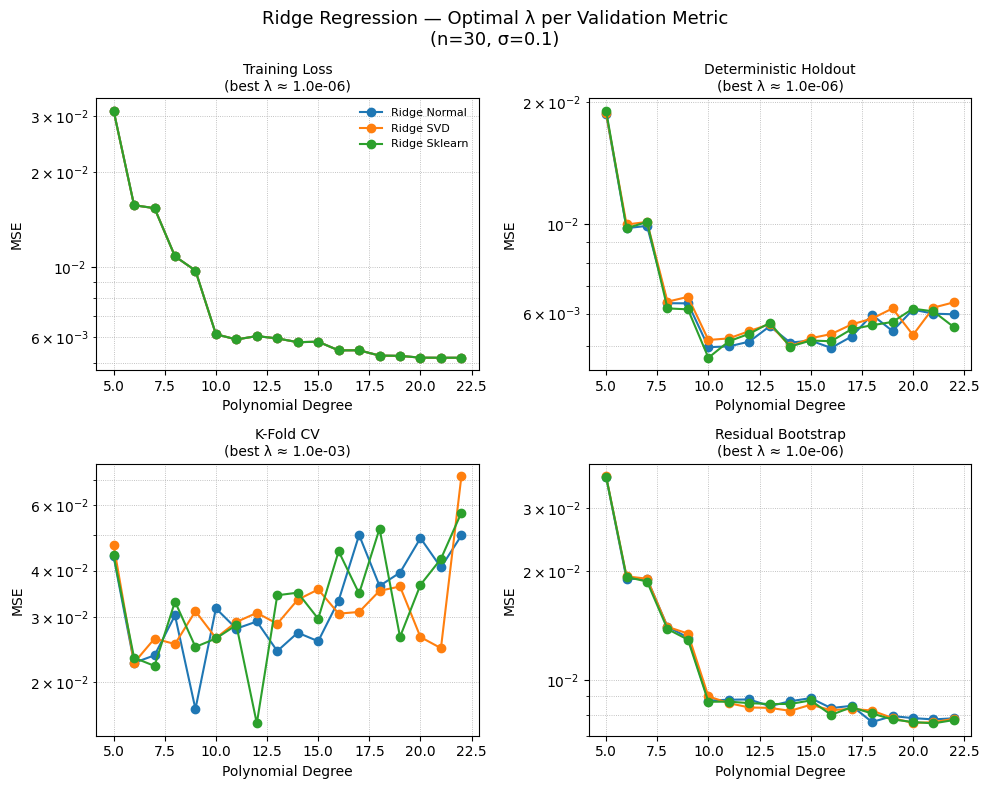

Saved plot to:
c:\Users\vikto\Desktop\fysstk3155\project-1\code\figures\ridge_validation_optimal_lambda.pdf


In [9]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(314)
from src.data import equispaced_points, runge_function
from src.basis import vandermonde
from src.regression import ridge_normal, ridge_svd, ridge_sklearn
from src.validation import deterministic_holdout, kfold_cv, residual_bootstrap

# -------------------
# Config
# -------------------
degrees = np.arange(5, 23)
lambdas = np.logspace(-6, -1, 6)   # grid of λ values
x = equispaced_points(30)
y_true = runge_function(x)
y = y_true + np.random.normal(0, 0.1, size=len(x))

solvers = {
    "Ridge Normal": ridge_normal,
    "Ridge SVD": ridge_svd,
    "Ridge Sklearn": ridge_sklearn,
}
methods = ["Training Loss", "Deterministic Holdout", "K-Fold CV", "Residual Bootstrap"]

# -------------------
# Grid Search for Optimal λ
# -------------------
opt_lambda = {m: {} for m in methods}
results_best = {m: {s: [] for s in solvers} for m in methods}

for method in methods:
    print(f"Searching λ for {method}...")

for d in degrees:
    X = vandermonde(x, d)

    for solver_name, solver in solvers.items():
        # Store metric curves for different lambdas
        metric_curves = {m: [] for m in methods}

        for lam in lambdas:
            coef, predict_fn, info = solver(X, y, lam)
            y_pred = predict_fn(X, coef)
            train_loss = np.mean((y - y_pred) ** 2)

            metric_curves["Training Loss"].append(train_loss)
            metric_curves["Deterministic Holdout"].append(
                deterministic_holdout(x, y_true, runge_function, d,
                                      lambda X_, y_: solver(X_, y_, lam), B=40, sigma=0.1)
            )
            metric_curves["K-Fold CV"].append(
                kfold_cv(x, y, d, lambda X_, y_: solver(X_, y_, lam), K=5)
            )
            metric_curves["Residual Bootstrap"].append(
                residual_bootstrap(x, y, d, lambda X_, y_: solver(X_, y_, lam), B=40)
            )

        # Pick best λ for each method (minimizing the metric)
        for m in methods:
            best_idx = np.argmin(metric_curves[m])
            opt_lambda[m][solver_name] = lambdas[best_idx]
            results_best[m][solver_name].append(metric_curves[m][best_idx])

# -------------------
# Plot 2×2 Validation Grid (best λ per metric)
# -------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
colors = {"Ridge Normal": "C0", "Ridge SVD": "C1", "Ridge Sklearn": "C2"}

for i, method in enumerate(methods):
    ax = axes[i]
    for solver_name, color in colors.items():
        ax.plot(degrees, results_best[method][solver_name], "o-", label=solver_name, color=color)
        ax.set_title(f"{method}\n(best λ ≈ {opt_lambda[method][solver_name]:.1e})", fontsize=10)
    ax.set_xlabel("Polynomial Degree")
    ax.set_ylabel("MSE")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle=":", linewidth=0.6)
    if i == 0:
        ax.legend(frameon=False, fontsize=8)

# Add full experimental context back in the supertitle
fig.suptitle(
    f"Ridge Regression — Optimal λ per Validation Metric\n(n={len(x)}, σ=0.1)",
    fontsize=13,
    y=0.98
)
plt.tight_layout()
plt.show()

# -------------------
# Save
# -------------------
fig_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
os.makedirs(fig_dir, exist_ok=True)
out_path = os.path.join(fig_dir, "ridge_validation_optimal_lambda.pdf")
fig.savefig(out_path, bbox_inches="tight")
print(f"Saved plot to:\n{out_path}")


c:\Users\vikto\Desktop\fysstk3155\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\vikto\Desktop\fysstk3155\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\vikto\Desktop\fysstk3155\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\vikto\Desktop\fysstk3155\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.wa

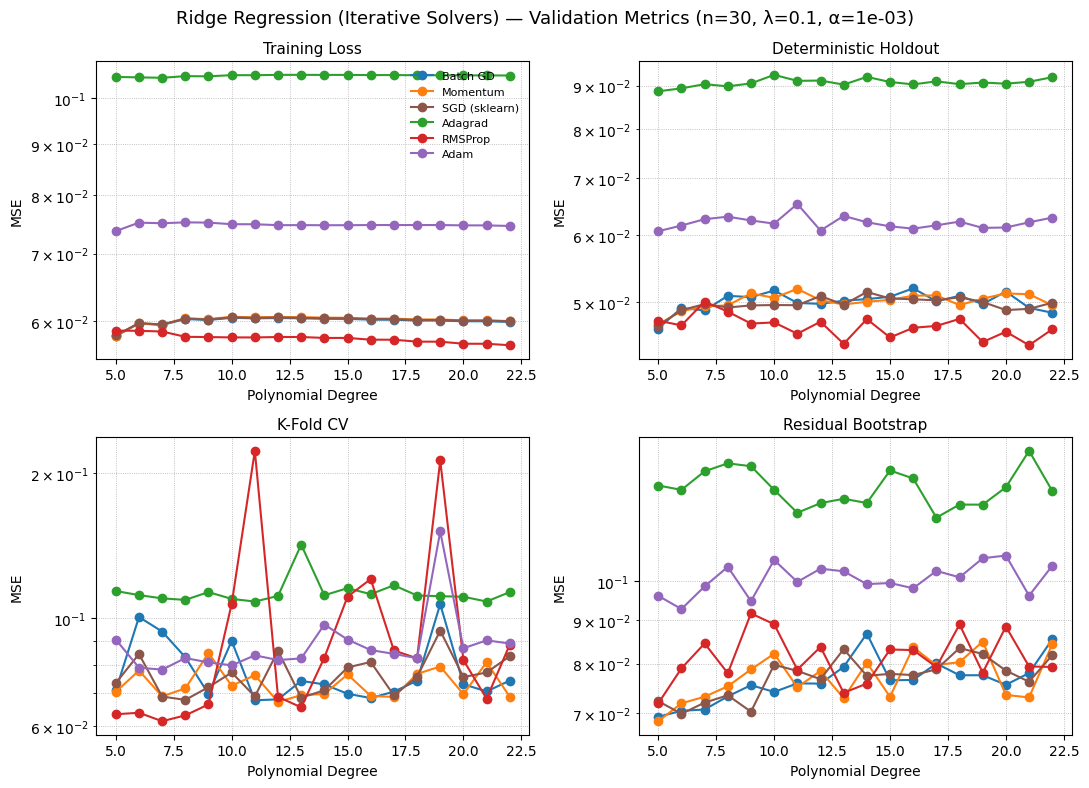

Saved 2×2 Ridge GD validation plot to:
c:\Users\vikto\Desktop\fysstk3155\project-1\code\figures\ridge_gd_validation_metrics_2x2.pdf


In [3]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))


import numpy as np
import matplotlib.pyplot as plt
import torch
np.random.seed(314)

from src.data import equispaced_points, runge_function
from src.basis import vandermonde
from src.gd import (
    batch_gradient_descent,
    momentum_gradient_descent,
    adagrad_solver,
    rmsprop_solver,
    adam_solver,
    sgd_sklearn,  # Add this
    ridge_gradient,
)
from src.validation import deterministic_holdout, kfold_cv, residual_bootstrap

# -------------------
# Config
# -------------------
degrees = np.arange(5, 23)
alpha = 1e-3  # Ridge penalty

x = equispaced_points(30)
y = runge_function(x) + np.random.normal(0, 0.1, size=len(x))

# Define Ridge loss for PyTorch optimizers
mse_fn = torch.nn.MSELoss()
def ridge_loss_fn(X_t, y_t, theta):
    return mse_fn(X_t @ theta, y_t) + alpha * torch.sum(theta ** 2)

solvers = {
    "Batch GD": lambda X, y: batch_gradient_descent(X, y, eta=1e-3, max_iter=400, grad_fn=ridge_gradient(X, y, alpha)),
    "Momentum": lambda X, y: momentum_gradient_descent(X, y, eta=1e-3, beta=0.9, max_iter=400, grad_fn=ridge_gradient(X, y, alpha)),
    "SGD (sklearn)": lambda X, y: sgd_sklearn(X, y, eta=1e-3, max_iter=400, alpha=alpha),  # Add this
    "Adagrad": lambda X, y: adagrad_solver(X, y, lr=5e-3, max_iter=400, loss_fn=ridge_loss_fn),
    "RMSProp": lambda X, y: rmsprop_solver(X, y, lr=1e-3, max_iter=400, loss_fn=ridge_loss_fn),
    "Adam": lambda X, y: adam_solver(X, y, lr=1e-3, max_iter=400, loss_fn=ridge_loss_fn),
}

methods = ["Training Loss", "Deterministic Holdout", "K-Fold CV", "Residual Bootstrap"]
results = {m: {s: [] for s in solvers} for m in methods}

# -------------------
# Lightened sampling
# -------------------
HOLDOUT_B = 5
BOOTSTRAP_B = 5
K_FOLDS = 3

# -------------------
# Compute metrics
# -------------------
for d in degrees:
    X = vandermonde(x, d)
    for name, solver in solvers.items():
        coef, predict_fn, info = solver(X, y)
        y_pred_train = predict_fn(X, coef)
        train_loss = np.mean((y - y_pred_train) ** 2)

        results["Training Loss"][name].append(train_loss)
        results["Deterministic Holdout"][name].append(
            deterministic_holdout(x, y, runge_function, d, solver, B=HOLDOUT_B, sigma=0.1)
        )
        results["K-Fold CV"][name].append(kfold_cv(x, y, d, solver, K=K_FOLDS))
        results["Residual Bootstrap"][name].append(
            residual_bootstrap(x, y, d, solver, B=BOOTSTRAP_B)
        )

# -------------------
# Plot 2×2 Validation Grid
# -------------------
fig, axes = plt.subplots(2, 2, figsize=(11, 8))
axes = axes.ravel()

colors = {
    "Batch GD": "C0",
    "Momentum": "C1",
    "SGD (sklearn)": "C5",
    "Adagrad": "C2",
    "RMSProp": "C3",
    "Adam": "C4",
}

for i, method in enumerate(methods):
    ax = axes[i]
    for solver_name, color in colors.items():
        ax.plot(degrees, results[method][solver_name], "o-", label=solver_name, color=color)
    ax.set_title(method, fontsize=11)
    ax.set_xlabel("Polynomial Degree")
    ax.set_ylabel("MSE")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle=":", linewidth=0.6)
    if i == 0:
        ax.legend(frameon=False, fontsize=8)

fig.suptitle(
    f"Ridge Regression (Iterative Solvers) — Validation Metrics (n=30, λ=0.1, α={alpha:.0e})",
    fontsize=13,
    y=0.98,
)
plt.tight_layout()
plt.show()

# -------------------
# Save results
# -------------------
fig_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
os.makedirs(fig_dir, exist_ok=True)

out_path = os.path.join(fig_dir, 'ridge_gd_validation_metrics_2x2.pdf')
fig.savefig(out_path, bbox_inches="tight")
print(f"Saved 2×2 Ridge GD validation plot to:\n{out_path}")